## 导入模型

In [2]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)

X_train = []
X_test = []

for filename in ["feature_resnet50.h5", "feature_xception.h5", "feature_inception_v3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

## 构建模型

In [3]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


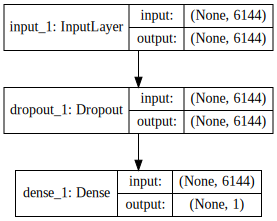

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [5]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_split=0.2)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 80us/step - loss: 0.0674 - acc: 0.9768 - val_loss: 0.0203 - val_acc: 0.9940
Epoch 2/10
20000/20000 [==============================] - 1s 45us/step - loss: 0.0218 - acc: 0.9926 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 3/10
20000/20000 [==============================] - 1s 44us/step - loss: 0.0184 - acc: 0.9940 - val_loss: 0.0156 - val_acc: 0.9942
Epoch 4/10
20000/20000 [==============================] - 1s 43us/step - loss: 0.0142 - acc: 0.9953 - val_loss: 0.0157 - val_acc: 0.9940
Epoch 5/10
20000/20000 [==============================] - 1s 42us/step - loss: 0.0136 - acc: 0.9952 - val_loss: 0.0161 - val_acc: 0.9938
Epoch 6/10
20000/20000 [==============================] - 1s 42us/step - loss: 0.0123 - acc: 0.9959 - val_loss: 0.0154 - val_acc: 0.9944
Epoch 7/10
20000/20000 [==============================] - 1s 43us/step - loss: 0.0125 - acc: 0.9959 - val_loss: 0.0159 - val_acc:

In [6]:
# 保存模型
model.save('merged_train_model.h5')

In [7]:
# 模型预测
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 1s 43us/step


In [8]:
# 测试集预测
import os
import pandas as pd
from keras.preprocessing.image import *

# 获得当前目录
current_dir = os.getcwd()
df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(current_dir + "/data/test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('merged_pred_t.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


0.03961